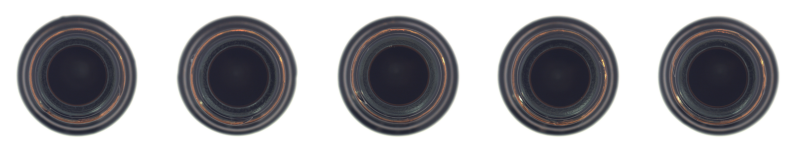

In [49]:
import os
import cv2
import matplotlib.pyplot as plt

# Define dataset path
dataset_path = "C:/Users/shsoaa/Downloads/mvtec/mvtec_anomaly_detection/"

# Select category (e.g., 'bottle')
category = "bottle"
train_good_path = os.path.join(dataset_path, category, "train/good")

# Load a few images
image_files = [f for f in os.listdir(train_good_path) if f.endswith(".png")]
sample_images = [cv2.imread(os.path.join(train_good_path, img)) for img in image_files[:5]]

# Plot images
plt.figure(figsize=(10, 5))
for i, img in enumerate(sample_images):
    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()


In [50]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from PIL import Image

# Correct dataset path
dataset_path = r"C:/Users/shsoaa/Downloads/mvtec/mvtec_anomaly_detection/"  # Use raw string (r"...")

class MultiClassMVTecDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = []

        # Get only valid directories (skip files like license.txt)
        categories = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

        for category in categories:
            category_path = os.path.join(root_dir, category, "test")

            if not os.path.exists(category_path):
                continue  # Skip if 'test' folder doesn't exist

            # Load good images (label 0)
            good_dir = os.path.join(category_path, "good")
            if os.path.exists(good_dir):
                for img_name in os.listdir(good_dir):
                    self.images.append(os.path.join(good_dir, img_name))
                    self.labels.append(0)  # Label 0 = No defect
                    self.classes.append(category)

            # Load defective images (label 1)
            defect_types = [d for d in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, d)) and d != "good"]
            for defect_type in defect_types:
                defect_dir = os.path.join(category_path, defect_type)
                for img_name in os.listdir(defect_dir):
                    self.images.append(os.path.join(defect_dir, img_name))
                    self.labels.append(1)  # Label 1 = Defective
                    self.classes.append(category)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        label = self.labels[idx]
        category = self.classes[idx]  # Store category info
        
        if self.transform:
            image = self.transform(image)
            
        return image, label, category

# Define transformations
import torchvision.transforms as transforms

# Training Transform (with augmentations)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Validation Transform (NO augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])




# Load dataset separately for training and validation
train_dataset = MultiClassMVTecDataset(root_dir=dataset_path, transform=train_transform)
val_dataset = MultiClassMVTecDataset(root_dir=dataset_path, transform=val_transform)

# Split the dataset manually (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, _ = random_split(train_dataset, [train_size, val_size])  # Train set
_, val_dataset = random_split(val_dataset, [train_size, val_size])  # Validation set
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


print(f"✅ Dataset Loaded Successfully")
print(f"Total Images: {len(dataset)}")
print(f"Training Samples: {len(train_dataset)}, Validation Samples: {len(val_dataset)}")


✅ Dataset Loaded Successfully
Total Images: 1725
Training Samples: 1380, Validation Samples: 345


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Load Pretrained ResNet-18 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

# Modify the last layer for binary classification (Good vs Defective)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: Good (0), Defective (1)

model = model.to(device)

# Loss Function & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print("✅ Model Loaded and Ready for Training")


✅ Model Loaded and Ready for Training


In [52]:
from tqdm import tqdm  # For progress bar

# Training Loop
num_epochs = 30  # Adjust based on results

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels, _ in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs} - Loss: {running_loss:.4f} - Train Acc: {train_acc:.2f}%")

print("🎯 Training Complete!")


100%|██████████| 87/87 [01:54<00:00,  1.32s/it]


Epoch 1/30 - Loss: 55.2993 - Train Acc: 68.33%


100%|██████████| 87/87 [02:32<00:00,  1.75s/it]


Epoch 2/30 - Loss: 46.1018 - Train Acc: 75.65%


100%|██████████| 87/87 [02:34<00:00,  1.78s/it]


Epoch 3/30 - Loss: 43.4974 - Train Acc: 75.87%


100%|██████████| 87/87 [02:34<00:00,  1.78s/it]


Epoch 4/30 - Loss: 40.8281 - Train Acc: 78.62%


100%|██████████| 87/87 [02:32<00:00,  1.76s/it]


Epoch 5/30 - Loss: 39.4826 - Train Acc: 77.61%


100%|██████████| 87/87 [02:34<00:00,  1.77s/it]


Epoch 6/30 - Loss: 38.1550 - Train Acc: 80.43%


100%|██████████| 87/87 [02:32<00:00,  1.75s/it]


Epoch 7/30 - Loss: 36.1066 - Train Acc: 80.29%


100%|██████████| 87/87 [02:30<00:00,  1.73s/it]


Epoch 8/30 - Loss: 34.0342 - Train Acc: 82.68%


100%|██████████| 87/87 [02:33<00:00,  1.76s/it]


Epoch 9/30 - Loss: 34.0358 - Train Acc: 82.03%


100%|██████████| 87/87 [02:38<00:00,  1.82s/it]


Epoch 10/30 - Loss: 34.0280 - Train Acc: 81.88%


100%|██████████| 87/87 [02:34<00:00,  1.77s/it]


Epoch 11/30 - Loss: 28.8179 - Train Acc: 85.14%


100%|██████████| 87/87 [02:37<00:00,  1.81s/it]


Epoch 12/30 - Loss: 30.7083 - Train Acc: 85.14%


100%|██████████| 87/87 [02:31<00:00,  1.74s/it]


Epoch 13/30 - Loss: 28.8702 - Train Acc: 85.51%


100%|██████████| 87/87 [02:37<00:00,  1.81s/it]


Epoch 14/30 - Loss: 27.8762 - Train Acc: 85.65%


100%|██████████| 87/87 [02:34<00:00,  1.78s/it]


Epoch 15/30 - Loss: 27.9223 - Train Acc: 86.09%


100%|██████████| 87/87 [02:35<00:00,  1.79s/it]


Epoch 16/30 - Loss: 25.3980 - Train Acc: 88.33%


100%|██████████| 87/87 [02:35<00:00,  1.79s/it]


Epoch 17/30 - Loss: 26.0509 - Train Acc: 87.39%


100%|██████████| 87/87 [02:32<00:00,  1.75s/it]


Epoch 18/30 - Loss: 24.5168 - Train Acc: 88.41%


100%|██████████| 87/87 [01:32<00:00,  1.06s/it]


Epoch 19/30 - Loss: 24.1103 - Train Acc: 88.70%


100%|██████████| 87/87 [01:21<00:00,  1.07it/s]


Epoch 20/30 - Loss: 23.8601 - Train Acc: 88.48%


100%|██████████| 87/87 [01:23<00:00,  1.04it/s]


Epoch 21/30 - Loss: 26.6072 - Train Acc: 88.41%


100%|██████████| 87/87 [01:22<00:00,  1.05it/s]


Epoch 22/30 - Loss: 23.3358 - Train Acc: 88.77%


100%|██████████| 87/87 [01:29<00:00,  1.03s/it]


Epoch 23/30 - Loss: 21.8700 - Train Acc: 90.00%


100%|██████████| 87/87 [01:24<00:00,  1.02it/s]


Epoch 24/30 - Loss: 22.6633 - Train Acc: 88.48%


100%|██████████| 87/87 [01:21<00:00,  1.07it/s]


Epoch 25/30 - Loss: 21.1842 - Train Acc: 90.58%


100%|██████████| 87/87 [01:19<00:00,  1.09it/s]


Epoch 26/30 - Loss: 23.2453 - Train Acc: 88.55%


100%|██████████| 87/87 [01:24<00:00,  1.03it/s]


Epoch 27/30 - Loss: 22.1621 - Train Acc: 89.49%


100%|██████████| 87/87 [01:25<00:00,  1.01it/s]


Epoch 28/30 - Loss: 22.5817 - Train Acc: 90.14%


100%|██████████| 87/87 [01:18<00:00,  1.11it/s]


Epoch 29/30 - Loss: 22.7854 - Train Acc: 89.13%


100%|██████████| 87/87 [01:44<00:00,  1.20s/it]

Epoch 30/30 - Loss: 19.6136 - Train Acc: 89.49%
🎯 Training Complete!


In [53]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels, _ in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_acc = 100 * correct / total
print(f"✅ Model Validation Accuracy: {val_acc:.2f}%")


100%|██████████| 22/22 [00:28<00:00,  1.28s/it]

✅ Model Validation Accuracy: 91.88%


In [54]:
torch.save(model.state_dict(), "mvtec_model.pth")
print("✅ Model Saved Successfully!")


✅ Model Saved Successfully!


In [5]:
import torch
import torchvision.transforms as transforms
from fastapi import FastAPI, File, UploadFile
from PIL import Image
import io
import torchvision.models as models 

# Initialize ResNet18 model with the correct number of output classes (2)
model = models.resnet18(pretrained=False)
model.fc = torch.nn.Linear(512, 2)  # Modify the fully connected layer

# Load the saved model weights
model.load_state_dict(torch.load("mvtec_model.pth", map_location=torch.device("cpu")))

# Set model to evaluation mode
model.eval()

# Define transformations (should match validation transforms)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Initialize FastAPI
app = FastAPI()

@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    try:
        image = Image.open(io.BytesIO(await file.read())).convert("RGB")
        image = transform(image).unsqueeze(0)  # Add batch dimension

        with torch.no_grad():
            output = model(image)
            _, predicted = torch.max(output, 1)
        
        result = "Defective" if predicted.item() == 1 else "Good"
        return {"prediction": result}
    
    except Exception as e:
        return {"error": str(e)}


In [7]:
import requests

url = "http://127.0.0.1:8000/predict/"
files = {"file": open("C:/Users/shsoaa/Downloads/mvtec/mvtec_anomaly_detection/pill/test/crack/007.png", "rb")}
response = requests.post(url, files=files)

print(response.json())  # Output: {'prediction': 'Good' or 'Defective'}


ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /predict/ (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000022205CA8DF0>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))